## Generative Models Lab ##

Through these following 4 notebook, we will explore different techniques and approches using generatives models! Generative models are used to generate new data isntances within a distribution.

We will explore the following:

- What are generative models and how to use autoencoders for representing data distributions and generate content
    - Vector compression representation
- Use Variational AutoEncoders (VAE) to learn data distribution and generate variation of the content
- Deep Convolutional Generative Adversarial Networks (DCGAN) to generate content through generator-discriminator training
- Conditional DCGAN (cDCGAN): condition the generation so that we can target (condition) what is going to be generated

### Assignments ###

#### Mandatory: ####

- Interpolate from a latent space to another and visualize the transition using VAE and DCGAN (or GAN)
- Implement Generative Adversarial Networks (GAN) without convolutions
- Use images to condition Conditional GAN (cGAN)
- Test VAE and GAN using another task or dataset, and compare both approaches

#### Advanced: ####

- Implement and test Conditional VAE (cVAE)
- Implement and use vector arithmetic to the latent space using Conditional GANs (cGAN) or cVAE
- Implement Image Inpainting using Autoencoders or GANs

--------------

## AutoEncoders ##

<img src="../figures/ae.png" width="600">

This tutorial is based on Alfredo Canziani's work!

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
import random

In [2]:
IMG_SIZE = 28
batch_size = 256
# latent_dims = 30
latent_dims = 500  # denoise AE

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Helper method to convert vector to image

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), IMG_SIZE, IMG_SIZE)
    return x

In [4]:
# Displaying routine

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [5]:
dataset = MNIST('../data', transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]), download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, img_size, latent_dimension):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(img_size * img_size, latent_dimension),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dimension, img_size * img_size),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    


In [26]:
def train(denoise = False, num_epochs = 5, display_imgs = True):
    
    do = nn.Dropout() # Same as creating rnd tensor.
    noise = None
    for epoch in range(num_epochs):
        
        for data in dataloader:
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1) # Flatten
            
            # Check if the task is to denoise or not
            if denoise:
                noise = do(torch.ones(img.shape)).to(device)
#                 noise = torch.randint(low=1, high=2, size=img.shape).to(device)
                transformed_img = (img * noise).to(device)
            else:
                transformed_img = img
                
            output = model(transformed_img)
            loss = criterion(output, img.data)

            # Remember we need to zero_grad because the gradients accumulate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            
        print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
        
        # Print imgs if wanted
        if display_imgs:
            display_images(transformed_img, output)
            
    return [output, noise, transformed_img, img]

epoch [1/5], loss:0.0735
epoch [2/5], loss:0.0579
epoch [3/5], loss:0.0548
epoch [4/5], loss:0.0520
epoch [5/5], loss:0.0509


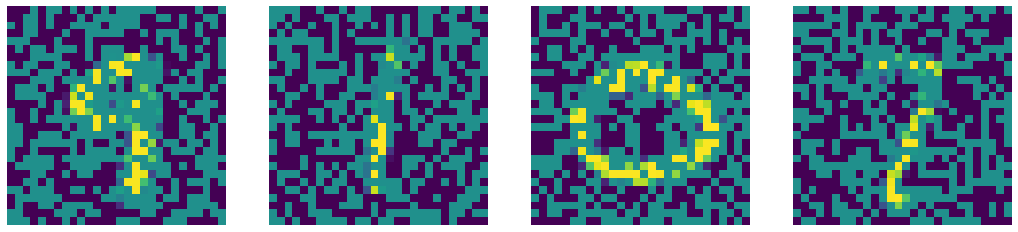

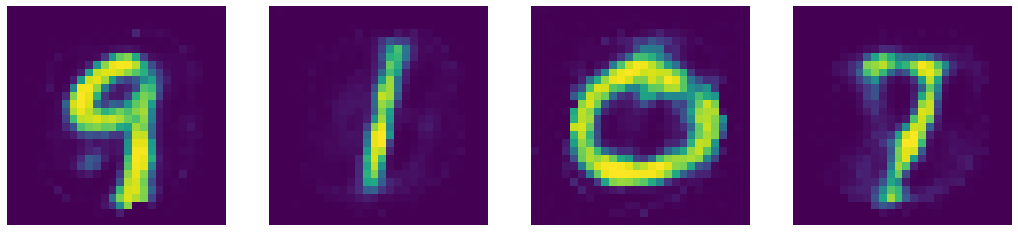

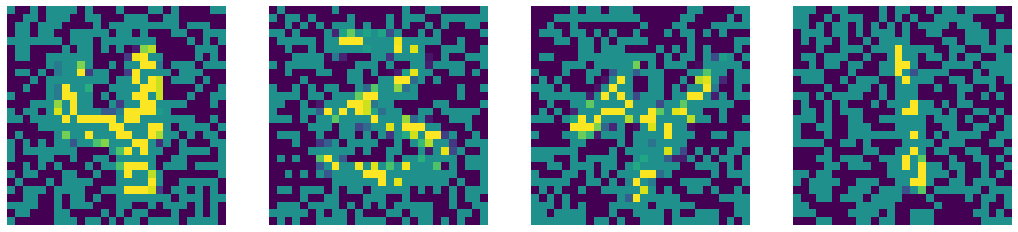

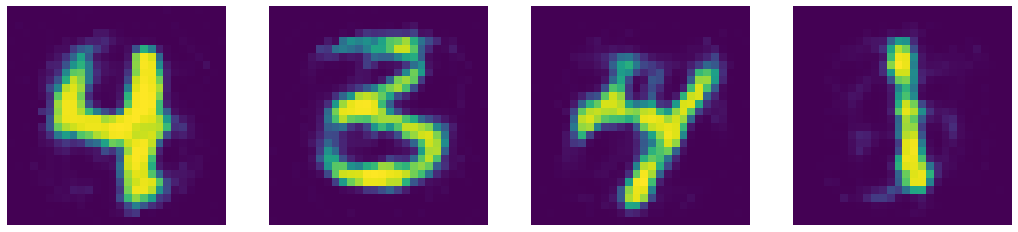

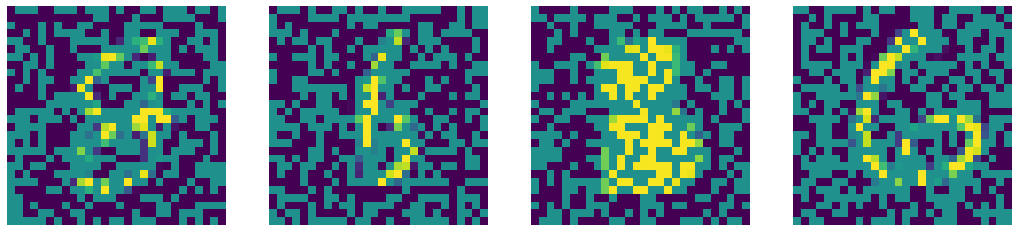

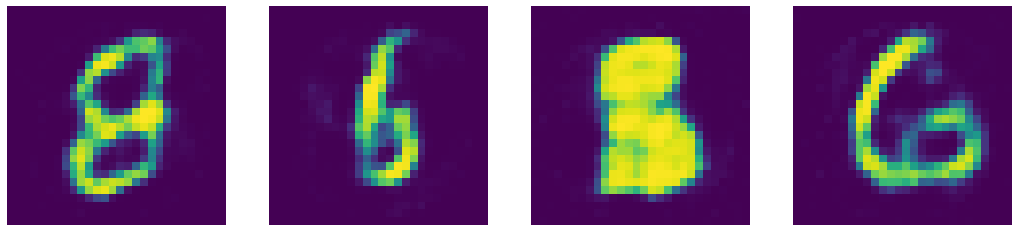

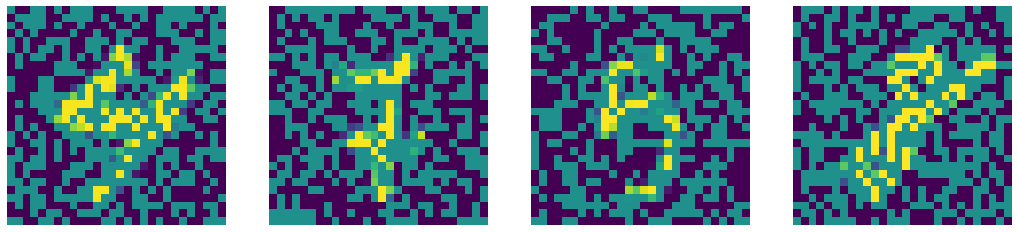

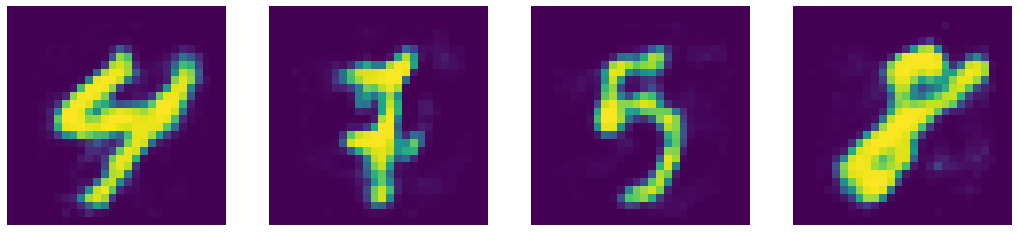

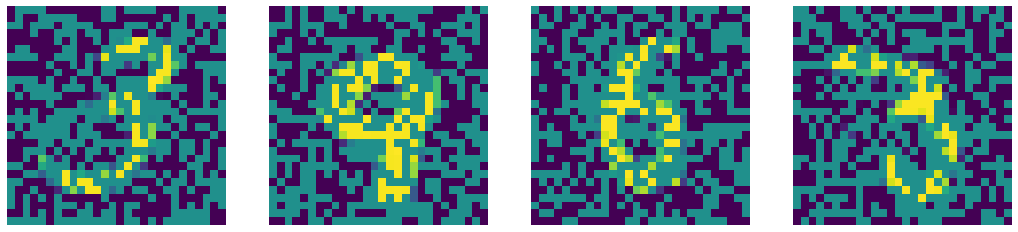

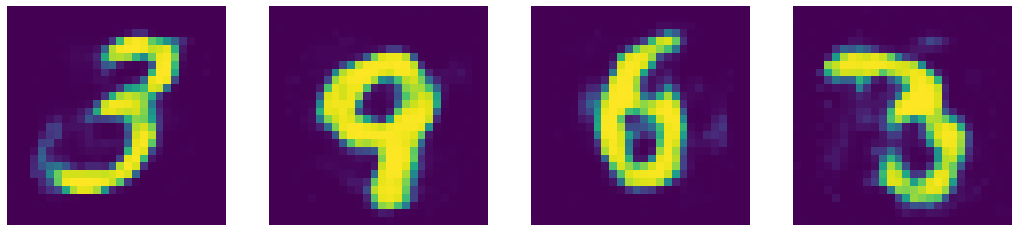

In [27]:
# Configure the optimiser

model = Autoencoder(IMG_SIZE, latent_dims).to(device)
criterion = nn.MSELoss()

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

train_output = train(denoise = True)

In [ ]:
# If wanted we can visualize kernels simply by passing the right layer

display_images(None, model.encoder[0].weight, 5)

In [28]:
# Let's compare the autoencoder inpainting capabilities vs. OpenCV

from cv2 import inpaint, INPAINT_NS, INPAINT_TELEA

In [29]:
# Inpaint with Telea and Navier-Stokes methods

dst_TELEA = list()
dst_NS = list()

for i in range(3, 7):
    corrupted_img = ((train_output[2].data.cpu()[i].view(IMG_SIZE, IMG_SIZE) / 4 + 0.5) * 255).byte().numpy()
    mask = 2 - train_output[1].cpu()[i].view(IMG_SIZE, IMG_SIZE).byte().numpy()
    dst_TELEA.append(inpaint(corrupted_img, mask, 3, INPAINT_TELEA))
    dst_NS.append(inpaint(corrupted_img, mask, 3, INPAINT_NS))

tns_TELEA = [torch.from_numpy(d) for d in dst_TELEA]
tns_NS = [torch.from_numpy(d) for d in dst_NS]

TELEA = torch.stack(tns_TELEA).float()
NS = torch.stack(tns_NS).float()

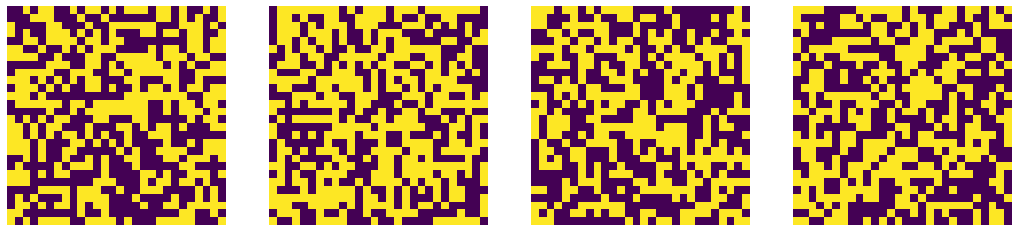

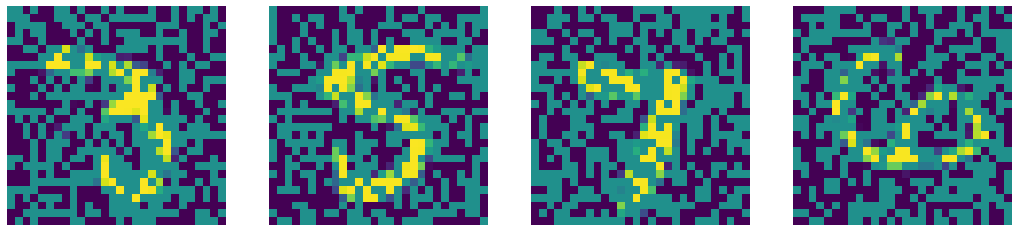

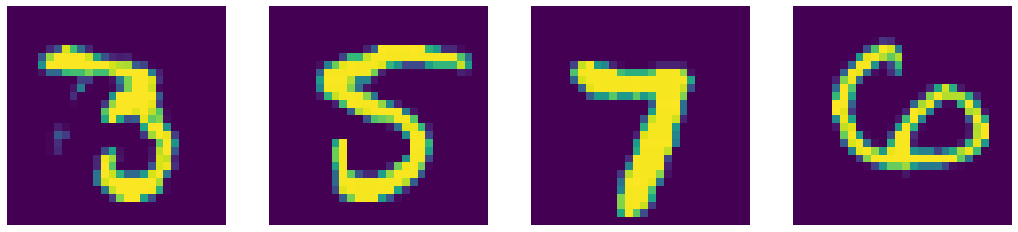

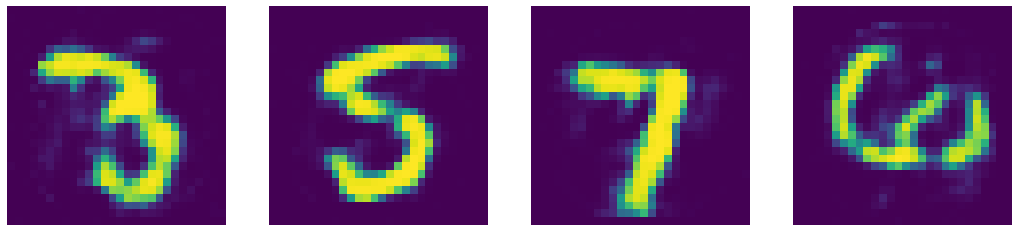

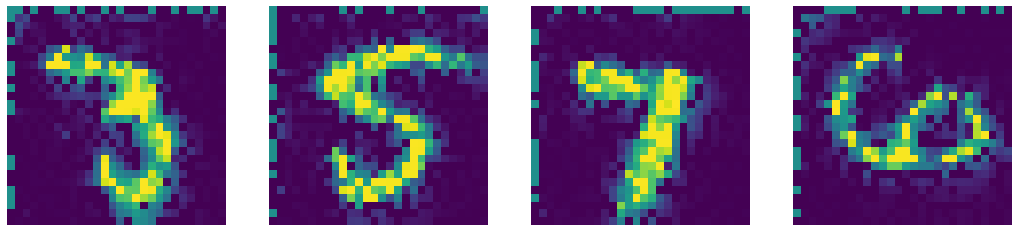

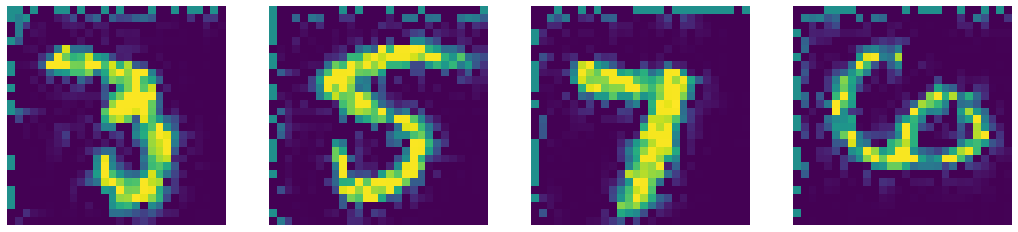

In [30]:
# Compare the results: [noise], [img + noise], [img], [AE, Telea, Navier-Stokes] inpainting

with torch.no_grad():
    display_images(train_output[1][3:7], train_output[2][3:7])
    display_images(train_output[3][3:7], train_output[0][3:7])
    display_images(TELEA, NS)

------------

You could implement here image inpainting when masking a chunk of the image rather than random noise (part of advanced assignment)